In [1]:
import json
import urllib.request
import os
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def download(json_dir_name):
    json_filenames=os.listdir(json_dir_name)
    print("Téléchargement en cours...")
    for i in range(len(json_filenames)):
        filename =  json_filenames[i]
        try:
            f=open(os.path.join(json_dir_name,filename))
            data=json.load(f)
            carac_image=data["image"]
            image_name= carac_image["original_filename"]
            url= carac_image["url"]
            urllib.request.urlretrieve(url, os.path.join("Dataset",image_name))
        except:
            print("Erreur dans le nom du fichier")
    print ("Téléchargement terminé")

In [3]:
#download(json_dir_name="rock-darwin")

In [4]:
def get_rock_dicts(image_dir,json_dir):
    dataset_dicts = []
    json_filenames=os.listdir(json_dir)
    for i in range(len(json_filenames)):
        record = {}
        filename=json_filenames[i]
        try:
            f=open(os.path.join(json_dir,filename))
            data=json.load(f)
        except:
            print(filename,"est corrompu")
            
        carac_image=data["image"]
        image_name= carac_image["original_filename"]
        image_name=os.path.join(image_dir,image_name)
        #print(image_name)
        height, width = cv2.imread(image_name).shape[:2]    
        record["file_name"] = image_name
        record["image_id"] = i
        record["height"] = height
        record["width"] = width
        
        annotations = data["annotations"]
        objs=[]
        for j in range(len(annotations)):
            ann=annotations[j]
            try:
                poly=ann["polygon"]
            except:
                continue
            poly= poly["path"]
            px= [p["x"] for p in poly]
            py= [p["y"] for p in poly]
            poly= [(p["x"]+0.5,p["y"]+0.5) for p in poly]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts



In [5]:
DatasetCatalog.register("rock_" + "train",lambda: get_rock_dicts(image_dir="Dataset",json_dir="rock-darwin"))
MetadataCatalog.get("rock_" + "train").set(thing_classes=["rock"])
rock_metadata = MetadataCatalog.get("rock_train")

In [6]:
dataset_dicts = get_rock_dicts(image_dir="Dataset",json_dir="rock-darwin")

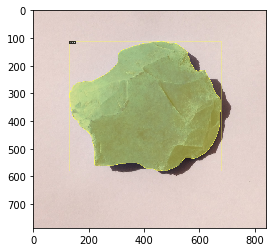

In [7]:
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rock_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [8]:
import warnings
warnings.filterwarnings("ignore")
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("rock_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS =2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.INPUT.MIN_SIZE_TRAIN=(800,)
cfg.SOLVER.BASE_LR = 1e-4  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000 # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (rock)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/10 10:10:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model!


[06/10 10:10:35 d2.engine.train_loop]: Starting training from iteration 0
[06/10 10:17:14 d2.utils.events]:  eta: 10:45:06  iter: 19  total_loss: 2.022  loss_cls: 0.877  loss_box_reg: 0.440  loss_mask: 0.693  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 20.0148  data_time: 0.0169  lr: 0.000002  max_mem: 0M
[06/10 10:23:21 d2.utils.events]:  eta: 10:28:43  iter: 39  total_loss: 1.909  loss_cls: 0.817  loss_box_reg: 0.397  loss_mask: 0.676  loss_rpn_cls: 0.001  loss_rpn_loc: 0.006  time: 19.1311  data_time: 0.0091  lr: 0.000004  max_mem: 0M
[06/10 10:29:51 d2.utils.events]:  eta: 10:22:18  iter: 59  total_loss: 1.772  loss_cls: 0.698  loss_box_reg: 0.394  loss_mask: 0.653  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 19.2674  data_time: 0.0104  lr: 0.000006  max_mem: 0M
[06/10 10:36:15 d2.utils.events]:  eta: 9:59:39  iter: 79  total_loss: 1.660  loss_cls: 0.571  loss_box_reg: 0.483  loss_mask: 0.604  loss_rpn_cls: 0.003  loss_rpn_loc: 0.008  time: 19.2497  data_time: 0.0121  lr: 0

In [19]:
cfg = get_cfg()
cfg.MODEL.DEVICE='cpu'
cfg.OUTPUT_DIR="RockNet-segmentation/trained-X101" #best model
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 1
#cfg.DATASETS.TEST = ("rock_val", )
predictor = DefaultPredictor(cfg)

In [20]:
def diff(dir1,dir2):
    folder1=os.listdir(dir1)
    folder2=os.listdir(dir2)
    folder3 = [name for name in folder1 if name not in folder2]
    return folder3
    

In [10]:
def predict(input_folder,save_folder):
    dir1=input_folder
    dir2="RockNet/PascalVOC800/JPEGImages"
    filenames = diff(dir1,dir2)
    print(" {} contient {} images".format(dir1,len(os.listdir(dir1))))
    #filenames=os.listdir(input_folder)
    print("Prédictions pour {} images...".format(len(filenames)))
    for i in range(len(filenames)):
        image_path=os.path.join(input_folder,filenames[i])
        try:
            im=cv2.imread(image_path)
            outputs = predictor(im)
            v = Visualizer(im[:, :, ::-1],
                   metadata=rock_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
            v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            name=filenames[i]
            outpout_name=name[:-4]+"prediction.jpg"
            outpout_name=name[:-4]+".jpg"
            
            im=v.get_image()[:, :, ::-1]
            cv2.imwrite(os.path.join(save_folder,outpout_name), im)
            
        except:
            print(filenames[i],"n'est pas une image")
    
    print("Prédictions terminée")

In [11]:
predict(input_folder="rock-training-images",save_folder="Test-images")

 rock-training-images contient 892 images
Prédictions pour 703 images...
Prédictions terminée


In [14]:
classes=["rock"]
def create_metric_file(input_folder,output_folder):
    print("Création en cours")
    filenames=os.listdir(input_folder)
    for i in range(len(filenames)):
        try:
            image_path=os.path.join(input_folder,filenames[i])
            output=os.path.join(output_folder,filenames[i])
            file=open(output+".txt",'w')
            im=cv2.imread(image_path)
            outputs = predictor(im)
            instances=outputs["instances"].to("cpu")
            results=instances.get_fields()
            boxes=results["pred_boxes"]
            boxes=np.array(boxes.tensor)
            scores=results['scores']
            pred_classes=results["pred_classes"]
            for j in range(len(boxes)):
                xmin = int(boxes[j][0])
                ymin = int(boxes[j][1])
                xmax = int(boxes[j][2])
                ymax = int(boxes[j][3])
                file.write(classes[pred_classes[j]])
                file.write("\t")
                file.write(str(float(scores[j])))
                file.write("\t")
                file.write(str(int(xmin)))
                file.write("\t")
                file.write(str(int(ymin)))
                file.write("\t")
                file.write(str(int(xmax)))
                file.write("\t")
                file.write(str(int(ymax)))
                file.write("\n")
        except:
            print(filenames[i],"corrompu")
            continue
    print("Terminée")
                                

                                

                
                
        
    
    

In [13]:
create_metric_file(input_folder="Test-images",output_folder="RockNet-segmentation/Object-Detection-Metrics/detections")

Création en cours


AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
cfg.MODEL.DEVICE='cpu'
evaluator = COCOEvaluator("rock_train", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "rock_train")
#inference_on_dataset(trainer.model, val_loader, evaluator)
inference_on_dataset(predictor.model, val_loader, evaluator)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/cuda/Module.cpp:207